In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive')

In [ ]:
from zipfile import ZipFile
filename='/content/drive/MyDrive/AFO.zip'
with ZipFile(filename,'r') as zip:
  zip.extractall()

In [ ]:
!nvidia-smi

Sun Jun 18 06:01:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install super-gradients

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 66.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
  coco_detection_yolo_format_train,
  coco_detection_yolo_format_val
)

from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
  DetectionMetrics_050,
  DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random


[2023-06-18 06:01:28] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-18 06:01:35] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-06-18 06:01:37] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-18 06:01:37] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-18 06:01:37] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-18 06:01:37] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-06-18 06:01:37] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-06-18 06:01:37] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-06-18 06:01:37] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-06-18 06:01:37] WARNING

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/afoSet1'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir =  'images/validation'
val_labels_dir = 'labels/validation'
test_ings_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = [ 'human','wind/sup-board','boat','bouy','sailboat','kayak']

In [ ]:
dataset_params = {
  'data_dir' :ROOT_DIR,
  'train_images_dir' : train_imgs_dir,
  'train_labels_dir' : train_labels_dir,
  'val_images_dir' : val_imgs_dir,
  'val_labels_dir' :val_labels_dir,
  'test_images_dir' : test_ings_dir,
  'test_labels_dir' : test_labels_dir,
  'classes' : classes
}

In [ ]:
EPOCHS = 100
BATCH_SIZE = 8
WORKERS = 8

Visualize Ground truth images


In [ ]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))


In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin,xmax,ymax
def yolo2bbox(bboxes) :
  xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1] -bboxes[3]/2
  xmax, ymax =  bboxes[0]+ bboxes[2]/2, bboxes[1] + bboxes[3]/2
  return xmin, ymin, xmax, ymax

In [ ]:
def plot_box( image, bboxes, labels) :
  # Need the image height and width to denormalize
  # the bounding box coordinates
  height, width, _ = image.shape
  lw = max(round(sum(image.shape) / 2 * 0.003), 2) # Line width.
  tf = max(lw - 1, 1) # Font thickness.
  for box_num , box in enumerate(bboxes) :
    x1, y1, x2, y2 = yolo2bbox(box)
    # denormalize the coordinates
    xmin = int(x1*width)
    ymin = int(y1*height)
    xmax = int(x2*width)
    ymax = int(y2*height)


    p1, p2 =  (int(xmin), int(ymin)), (int(xmax), int(ymax))
    class_name = classes[int(labels[box_num])]
    color = colors[classes.index(class_name)]


    cv2. rectangle(
        image,
        p1,p2,
        color=color,
        thickness = lw,
        lineType= cv2.LINE_AA
    )


    #FOR FILLED RECTANGLE
    w, h = cv2.getTextSize(
        class_name,
        0,
        fontScale = lw/3,
        thickness = tf
    )[0]

    outside = p1[1] - h >= 3
    p2 = p1[0] + w , p1[1] - h -3 if outside else p1[1] + h + 3
    cv2.rectangle(
        image,
        p1,p2,
        color = color,
        thickness = -1 ,
        lineType = cv2.LINE_AA
    )

    cv2. putText(
      image,
      class_name,
      (p1[0], p1[1]- 5 if outside else p1[1] + h + 2),
      cv2.FONT_HERSHEY_SIMPLEX,
      fontScale = lw/3.5,
      color= (255, 255, 255),
      thickness=tf,
      lineType=cv2.LINE_AA
    )
  return image




In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
  all_training_images = glob.glob(image_path+'/*')
  all_training_labels = glob.glob(label_path+'/*')
  all_training_images.sort()
  all_training_labels.sort()

  temp = list(zip(all_training_images, all_training_labels))
  random.shuffle(temp)
  all_training_images, all_training_labels = zip(*temp)
  all_training_images, all_training_labels =  list(all_training_images), list(all_training_labels)

  num_images = len(all_training_images)

  if num_samples == -1:
    num_samples = num_images

  plt.figure(figsize= (15,12))
  for i in range (num_samples):
    image_name = all_training_images[i].split(os.path.sep)[-1]
    image = cv2.imread(all_training_images[i])
    with open(all_training_labels[i], 'r') as f:
      bboxes = []
      labels = []
      label_lines = f.readlines()
      for label_line in label_lines:
        label, x_c, y_c, w, h = label_line.split(' ')
        x_c = float(x_c)
        y_c = float(y_c)
        w = float(w)
        h = float(h)
        bboxes.append([x_c, y_c, w,h])
        labels.append(label)
    result_image = plot_box(image, bboxes, labels)
    plt.subplot(2, 2,i+1) #Visualize 2x2 grid of images.
    plt.imshow(image[:,:,::-1])
    plt.axis('off')
  plt.tight_layout()
  plt.show()



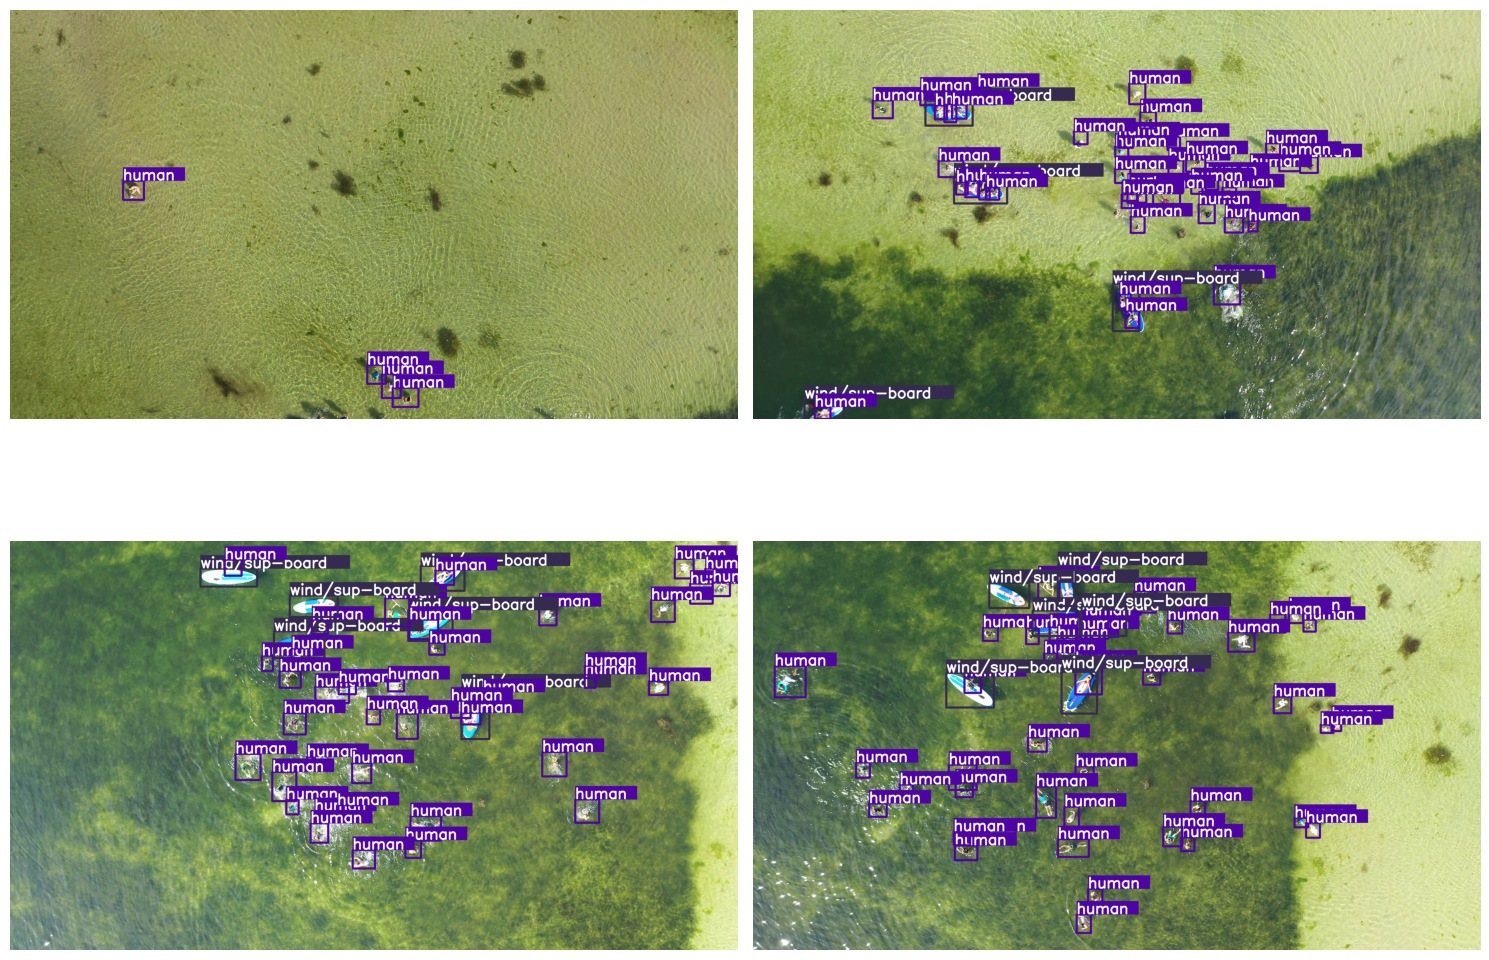

In [ ]:
# Visualize a few  training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir),
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4,
)

data prepration


In [ ]:
import collections
collections.Iterable = collections.abc.Iterable

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

Caching annotations: 100%|██████████| 1014/1014 [12:55<00:00,  1.31it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Caching annotations: 100%|█████████▉| 551/552 [07:06<00:00,  1.45it/s]

Transforms and Augmentations


In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [ ]:
train_data.dataset.transforms[0]

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114)

In [ ]:
############ An example on how to modify augmentations ###########
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

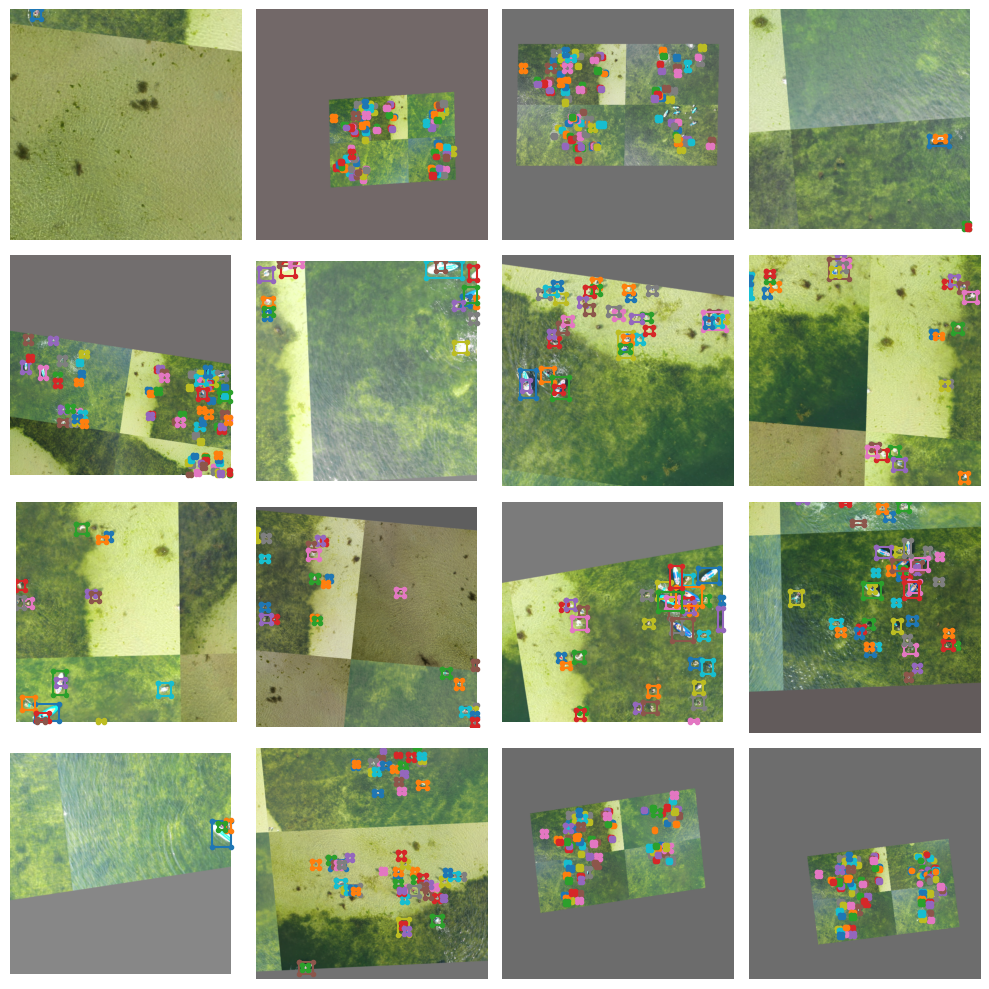

In [ ]:
# We visualize the images with augmentation here.
train_data.dataset.plot(plot_transformed_data=True)

In [ ]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
 }


In [ ]:
models_to_train = [
    #'yolo_nas_s'
    #'yolo_nas_m',
    'yolo_nas_l'
]

In [ ]:
CHECKPOINT_DIR = 'checkpoints'

Model Training

In [ ]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train,
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train,
        num_classes=len(dataset_params['classes']),
        pretrained_weights="coco"
    )

    trainer.train(
        model=model,
        training_params=train_params,
        train_loader=train_data,
        valid_loader=val_data
    )

Caching annotations: 100%|██████████| 552/552 [07:07<00:00,  1.29it/s]
[2023-06-18 06:22:42] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:04<00:00, 61.0MB/s]


The console stream is now moved to checkpoints/yolo_nas_l/console_Jun18_06_22_54.txt


[2023-06-18 06:22:54] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-06-18 06:23:55] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 975        (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         121        (len(train_loader))
    - Gradient updates per epoch:   121        (len(train_loader) / batch_accumulate)

[2023-06-18 06:23:55] INFO - sg_trainer.py - Started training for 100 epochs (0/99)

Validation epoch 0: 100%|██████████| 69/69 [00:50<00:00,  1.38it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.642
│   ├── Ppyoloeloss/loss_cls = 2.1797
│   ├── Ppyoloeloss/loss_dfl = 1.0091
│   └── Ppyoloeloss/loss_iou = 0.3831
└── Validation
    ├── F1@0.50 = 0.0
    ├── F1@0.50:0.95 = 0.0
    ├── Map@0.50 = 0.0004
    ├── Map@0.50:0.95 = 0.0001
    ├── Ppyoloeloss/loss = 3.3957
    ├── Ppyoloeloss/loss_cls = 2.495
    ├── Ppyoloeloss/loss_dfl = 0.6627
    ├── Ppyoloeloss/loss_iou = 0.2277
    ├── Precision@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50 = 0.0
    └── Recall@0.50:0.95 = 0.0



[2023-06-18 06:35:39] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-06-18 06:35:39] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.00011331566201988608
Validation epoch 1: 100%|██████████| 69/69 [00:49<00:00,  1.41it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.0358
│   │   ├── Best until now = 3.642  (↘ -1.6062)
│   │   └── Epoch N-1      = 3.642  (↘ -1.6062)
│   ├── Ppyoloeloss/loss_cls = 0.9029
│   │   ├── Best until now = 2.1797 (↘ -1.2768)
│   │   └── Epoch N-1      = 2.1797 (↘ -1.2768)
│   ├── Ppyoloeloss/loss_dfl = 0.7401
│   │   ├── Best until now = 1.0091 (↘ -0.269)
│   │   └── Epoch N-1      = 1.0091 (↘ -0.269)
│   └── Ppyoloeloss/loss_iou = 0.3051
│       ├── Best until now = 0.3831 (↘ -0.078)
│       └── Epoch N-1      = 0.3831 (↘ -0.078)
└── Validation
    ├── F1@0.50 = 0.0002
    │   ├── Best until now = 0.0    (↗ 0.0002)
    │   └── Epoch N-1      = 0.0    (↗ 0.0002)
    ├── F1@0.50:0.95 = 0.0
    │   ├── Best until now = 0.0    (↗ 0.0)
    │   └── Epoch N-1      = 0.0    (↗ 0.0)
    ├── Map@0.50 = 0.0229
    │   ├── Best until now = 0.0004 (↗ 0.0225)
    │   └── Epoch N-1      = 0.0004 (↗ 0.0225)
    ├── Map@0.50:0.95 = 0.0059
    │   ├── Best until now = 0.0001 (↗ 0

[2023-06-18 06:46:23] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-06-18 06:46:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.0058833397924900055
Validation epoch 2: 100%|██████████| 69/69 [00:47<00:00,  1.45it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 1.9006
│   │   ├── Best until now = 2.0358 (↘ -0.1352)
│   │   └── Epoch N-1      = 2.0358 (↘ -0.1352)
│   ├── Ppyoloeloss/loss_cls = 0.8345
│   │   ├── Best until now = 0.9029 (↘ -0.0684)
│   │   └── Epoch N-1      = 0.9029 (↘ -0.0684)
│   ├── Ppyoloeloss/loss_dfl = 0.7189
│   │   ├── Best until now = 0.7401 (↘ -0.0212)
│   │   └── Epoch N-1      = 0.7401 (↘ -0.0212)
│   └── Ppyoloeloss/loss_iou = 0.2827
│       ├── Best until now = 0.3051 (↘ -0.0225)
│       └── Epoch N-1      = 0.3051 (↘ -0.0225)
└── Validation
    ├── F1@0.50 = 0.0002
    │   ├── Best until now = 0.0002 (↗ 0.0)
    │   └── Epoch N-1      = 0.0002 (↗ 0.0)
    ├── F1@0.50:0.95 = 0.0001
    │   ├── Best until now = 0.0    (↗ 0.0)
    │   └── Epoch N-1      = 0.0    (↗ 0.0)
    ├── Map@0.50 = 0.0023
    │   ├── Best until now = 0.0229 (↘ -0.0206)
    │   └── Epoch N-1      = 0.0229 (↘ -0.0206)
    ├── Map@0.50:0.95 = 0.0009
    │   ├── Best until now = 0.0059 (

Validation epoch 3: 100%|██████████| 69/69 [00:49<00:00,  1.39it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 1.896
│   │   ├── Best until now = 1.9006 (↘ -0.0046)
│   │   └── Epoch N-1      = 1.9006 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_cls = 0.8351
│   │   ├── Best until now = 0.8345 (↗ 0.0006)
│   │   └── Epoch N-1      = 0.8345 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.7189
│   │   ├── Best until now = 0.7189 (↘ -1e-04)
│   │   └── Epoch N-1      = 0.7189 (↘ -1e-04)
│   └── Ppyoloeloss/loss_iou = 0.2806
│       ├── Best until now = 0.2827 (↘ -0.0021)
│       └── Epoch N-1      = 0.2827 (↘ -0.0021)
└── Validation
    ├── F1@0.50 = 0.0002
    │   ├── Best until now = 0.0002 (↗ 0.0)
    │   └── Epoch N-1      = 0.0002 (↗ 0.0)
    ├── F1@0.50:0.95 = 0.0001
    │   ├── Best until now = 0.0001 (↘ -0.0)
    │   └── Epoch N-1      = 0.0001 (↘ -0.0)
    ├── Map@0.50 = 0.0073
    │   ├── Best until now = 0.0229 (↘ -0.0156)
    │   └── Epoch N-1      = 0.0023 (↗ 0.005)
    ├── Map@0.50:0.95 = 0.0012
    │   ├── Best until now = 0.0059 (↘ -0.

Validation epoch 4: 100%|██████████| 69/69 [00:48<00:00,  1.42it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 1.8462
│   │   ├── Best until now = 1.896  (↘ -0.0498)
│   │   └── Epoch N-1      = 1.896  (↘ -0.0498)
│   ├── Ppyoloeloss/loss_cls = 0.8115
│   │   ├── Best until now = 0.8345 (↘ -0.023)
│   │   └── Epoch N-1      = 0.8351 (↘ -0.0236)
│   ├── Ppyoloeloss/loss_dfl = 0.7091
│   │   ├── Best until now = 0.7189 (↘ -0.0098)
│   │   └── Epoch N-1      = 0.7189 (↘ -0.0098)
│   └── Ppyoloeloss/loss_iou = 0.2721
│       ├── Best until now = 0.2806 (↘ -0.0085)
│       └── Epoch N-1      = 0.2806 (↘ -0.0085)
└── Validation
    ├── F1@0.50 = 0.0002
    │   ├── Best until now = 0.0002 (↗ 0.0)
    │   └── Epoch N-1      = 0.0002 (↗ 0.0)
    ├── F1@0.50:0.95 = 0.0001
    │   ├── Best until now = 0.0001 (↗ 0.0)
    │   └── Epoch N-1      = 0.0001 (↗ 0.0)
    ├── Map@0.50 = 0.0018
    │   ├── Best until now = 0.0229 (↘ -0.0211)
    │   └── Epoch N-1      = 0.0073 (↘ -0.0054)
    ├── Map@0.50:0.95 = 0.0004
    │   ├── Best until now = 0.0059 (↘

Validation epoch 5: 100%|██████████| 69/69 [00:47<00:00,  1.46it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 1.8235
│   │   ├── Best until now = 1.8462 (↘ -0.0226)
│   │   └── Epoch N-1      = 1.8462 (↘ -0.0226)
│   ├── Ppyoloeloss/loss_cls = 0.8039
│   │   ├── Best until now = 0.8115 (↘ -0.0076)
│   │   └── Epoch N-1      = 0.8115 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.7007
│   │   ├── Best until now = 0.7091 (↘ -0.0084)
│   │   └── Epoch N-1      = 0.7091 (↘ -0.0084)
│   └── Ppyoloeloss/loss_iou = 0.2677
│       ├── Best until now = 0.2721 (↘ -0.0043)
│       └── Epoch N-1      = 0.2721 (↘ -0.0043)
└── Validation
    ├── F1@0.50 = 0.0002
    │   ├── Best until now = 0.0002 (↗ 0.0)
    │   └── Epoch N-1      = 0.0002 (↗ 0.0)
    ├── F1@0.50:0.95 = 0.0001
    │   ├── Best until now = 0.0001 (↘ -0.0)
    │   └── Epoch N-1      = 0.0001 (↘ -0.0)
    ├── Map@0.50 = 0.0017
    │   ├── Best until now = 0.0229 (↘ -0.0212)
    │   └── Epoch N-1      = 0.0018 (↘ -0.0002)
    ├── Map@0.50:0.95 = 0.0006
    │   ├── Best until now = 0.0059

Validation epoch 6: 100%|██████████| 69/69 [00:48<00:00,  1.41it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 1.7928
│   │   ├── Best until now = 1.8235 (↘ -0.0307)
│   │   └── Epoch N-1      = 1.8235 (↘ -0.0307)
│   ├── Ppyoloeloss/loss_cls = 0.7904
│   │   ├── Best until now = 0.8039 (↘ -0.0135)
│   │   └── Epoch N-1      = 0.8039 (↘ -0.0135)
│   ├── Ppyoloeloss/loss_dfl = 0.6884
│   │   ├── Best until now = 0.7007 (↘ -0.0123)
│   │   └── Epoch N-1      = 0.7007 (↘ -0.0123)
│   └── Ppyoloeloss/loss_iou = 0.2633
│       ├── Best until now = 0.2677 (↘ -0.0044)
│       └── Epoch N-1      = 0.2677 (↘ -0.0044)
└── Validation
    ├── F1@0.50 = 0.0002
    │   ├── Best until now = 0.0002 (↘ -0.0)
    │   └── Epoch N-1      = 0.0002 (↘ -0.0)
    ├── F1@0.50:0.95 = 0.0001
    │   ├── Best until now = 0.0001 (↘ -0.0)
    │   └── Epoch N-1      = 0.0001 (↗ 0.0)
    ├── Map@0.50 = 0.0055
    │   ├── Best until now = 0.0229 (↘ -0.0174)
    │   └── Epoch N-1      = 0.0017 (↗ 0.0038)
    ├── Map@0.50:0.95 = 0.0021
    │   ├── Best until now = 0.0059

Validation epoch 7: 100%|██████████| 69/69 [00:54<00:00,  1.26it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 1.7766
│   │   ├── Best until now = 1.7928 (↘ -0.0162)
│   │   └── Epoch N-1      = 1.7928 (↘ -0.0162)
│   ├── Ppyoloeloss/loss_cls = 0.7807
│   │   ├── Best until now = 0.7904 (↘ -0.0097)
│   │   └── Epoch N-1      = 0.7904 (↘ -0.0097)
│   ├── Ppyoloeloss/loss_dfl = 0.6882
│   │   ├── Best until now = 0.6884 (↘ -0.0002)
│   │   └── Epoch N-1      = 0.6884 (↘ -0.0002)
│   └── Ppyoloeloss/loss_iou = 0.2607
│       ├── Best until now = 0.2633 (↘ -0.0025)
│       └── Epoch N-1      = 0.2633 (↘ -0.0025)
└── Validation
    ├── F1@0.50 = 0.0002
    │   ├── Best until now = 0.0002 (↘ -0.0)
    │   └── Epoch N-1      = 0.0002 (↘ -0.0)
    ├── F1@0.50:0.95 = 0.0001
    │   ├── Best until now = 0.0001 (↘ -0.0)
    │   └── Epoch N-1      = 0.0001 (↘ -0.0)
    ├── Map@0.50 = 0.0005
    │   ├── Best until now = 0.0229 (↘ -0.0224)
    │   └── Epoch N-1      = 0.0055 (↘ -0.005)
    ├── Map@0.50:0.95 = 0.0001
    │   ├── Best until now = 0.005

Validation epoch 8: 100%|██████████| 69/69 [00:52<00:00,  1.33it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 1.7773
│   │   ├── Best until now = 1.7766 (↗ 0.0006)
│   │   └── Epoch N-1      = 1.7766 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_cls = 0.7849
│   │   ├── Best until now = 0.7807 (↗ 0.0042)
│   │   └── Epoch N-1      = 0.7807 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.6912
│   │   ├── Best until now = 0.6882 (↗ 0.003)
│   │   └── Epoch N-1      = 0.6882 (↗ 0.003)
│   └── Ppyoloeloss/loss_iou = 0.2587
│       ├── Best until now = 0.2607 (↘ -0.002)
│       └── Epoch N-1      = 0.2607 (↘ -0.002)
└── Validation
    ├── F1@0.50 = 0.0003
    │   ├── Best until now = 0.0002 (↗ 0.0)
    │   └── Epoch N-1      = 0.0002 (↗ 0.0001)
    ├── F1@0.50:0.95 = 0.0001
    │   ├── Best until now = 0.0001 (↗ 0.0)
    │   └── Epoch N-1      = 0.0001 (↗ 0.0)
    ├── Map@0.50 = 0.001
    │   ├── Best until now = 0.0229 (↘ -0.0219)
    │   └── Epoch N-1      = 0.0005 (↗ 0.0005)
    ├── Map@0.50:0.95 = 0.0004
    │   ├── Best until now = 0.0059 (↘ -0.0055

Validation epoch 9: 100%|██████████| 69/69 [00:53<00:00,  1.28it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 1.7716
│   │   ├── Best until now = 1.7766 (↘ -0.0051)
│   │   └── Epoch N-1      = 1.7773 (↘ -0.0057)
│   ├── Ppyoloeloss/loss_cls = 0.7831
│   │   ├── Best until now = 0.7807 (↗ 0.0024)
│   │   └── Epoch N-1      = 0.7849 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.6869
│   │   ├── Best until now = 0.6882 (↘ -0.0013)
│   │   └── Epoch N-1      = 0.6912 (↘ -0.0043)
│   └── Ppyoloeloss/loss_iou = 0.258
│       ├── Best until now = 0.2587 (↘ -0.0007)
│       └── Epoch N-1      = 0.2587 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.0002
    │   ├── Best until now = 0.0003 (↘ -0.0)
    │   └── Epoch N-1      = 0.0003 (↘ -0.0)
    ├── F1@0.50:0.95 = 0.0001
    │   ├── Best until now = 0.0001 (↘ -0.0)
    │   └── Epoch N-1      = 0.0001 (↘ -0.0)
    ├── Map@0.50 = 0.0028
    │   ├── Best until now = 0.0229 (↘ -0.0201)
    │   └── Epoch N-1      = 0.001  (↗ 0.0017)
    ├── Map@0.50:0.95 = 0.0004
    │   ├── Best until now = 0.0059 

Train epoch 10:  37%|███▋      | 45/121 [04:02<04:28,  3.54s/it, PPYoloELoss/loss=1.75, PPYoloELoss/loss_cls=0.776, PPYoloELoss/loss_dfl=0.683, PPYoloELoss/loss_iou=0.254, gpu_mem=7.54]